In [1]:
# numpy and pandas for data manipulation
import numpy as np
import pandas as pd 
from sklearn.model_selection import (
    train_test_split,
    StratifiedKFold,
    RandomizedSearchCV
)
from sklearn.linear_model import LogisticRegression,RidgeClassifier, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.decomposition import KernelPCA
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB


from scipy.stats import randint, uniform
from scipy.stats import loguniform


from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.preprocessing import (
    OneHotEncoder,
    StandardScaler,
    MinMaxScaler
)

from sklearn.impute import SimpleImputer

from sklearn.feature_selection import (
    VarianceThreshold,
    SelectKBest,
    f_classif
)

from sklearn.svm import SVC



from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score,
    log_loss,
    roc_auc_score,
    f1_score,
    balanced_accuracy_score
)

# File system manangement
import os

# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')

# matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
X_train = pd.read_csv('../data/X_train.csv')
X_test = pd.read_csv('../data/X_test.csv')
y_train = pd.read_csv('../data/y_train.csv')
y_test = pd.read_csv('../data/y_test.csv')

In [4]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc  = le.transform(y_test)

In [5]:
cat_cols = X_train.select_dtypes(include=['object', 'category']).columns.tolist()
num_cols = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()



#### Numeric Pipeline

In [6]:
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', MinMaxScaler()) # try MinMaxScaler for logistic?
])


#### Categorical Pipeline

In [7]:
cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(
        handle_unknown='ignore',
        sparse_output=True
    ))
])

In [8]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_pipeline, num_cols),
        ('cat', cat_pipeline, cat_cols)
    ],
    remainder='passthrough'
)


In [9]:
# Remove near-constant features
feature_filter = VarianceThreshold(threshold=1e-4)


In [10]:
# Statistical feature selectio
feature_selector = SelectKBest(
    score_func=f_classif,
    k=300    # tuneable
)

# Full Pipline

In [11]:
from sklearn.base import clone

def build_pipeline(model):
    """
    Wraps preprocessing + model in a single pipeline
    """
    pipeline = Pipeline([
        ('preprocess', preprocessor),
        ('model', model)
    ])
    return pipeline


In [12]:
from sklearn.calibration import CalibratedClassifierCV
from sklearn.linear_model import LogisticRegression, PassiveAggressiveClassifier
from sklearn.naive_bayes import CategoricalNB, ComplementNB
from sklearn.neighbors import NearestCentroid, RadiusNeighborsClassifier
from sklearn.svm import SVC, NuSVC
from scipy.stats import loguniform
from sklearn.decomposition import PCA



# Dictionary of models + param grids
models = {
    'logistic': {
        'model': LogisticRegression(
            multi_class='multinomial',
            solver='saga',
            max_iter=5000,
            n_jobs=-1
        ),
        'params': {
            'model__C': loguniform(1e-3, 1e3),
            'model__penalty': ['l1', 'l2', 'elasticnet'],
            'model__fit_intercept': [True, False],
            'model__l1_ratio': [0, 0.5, 1]
        }
    },


        # 12️⃣ PCA + Logistic Regression pipeline
    'pca_logistic': {
        'model': Pipeline([
            ('pca', PCA()),
            ('logistic', LogisticRegression(
                multi_class='multinomial',
                solver='saga',
                max_iter=5000,
                n_jobs=-1
            ))
        ]),
        'params': {
            'pca__n_components': [5, 10, 15, 20],
            'logistic__C': loguniform(0.1, 100),
            'logistic__penalty': ['l1', 'l2', 'elasticnet'],
            'logistic__l1_ratio': [0, 0.5, 1]
        }
    },
    'ridge': {
        'model': RidgeClassifier(),
        'params': {
            'model__alpha': loguniform(1e-3, 100)
        }
    },

    'sgd': {
        'model': SGDClassifier(max_iter=5000, tol=1e-3, random_state=42),
        'params': {
            'model__loss': ['hinge', 'log', 'modified_huber'],
            'model__penalty': ['l2', 'l1', 'elasticnet'],
            'model__alpha': loguniform(1e-5, 1e-1)
        }
    },

       # --- Naive Bayes ---
    
    #----------------
    # Error
    #---------------
    # 'gaussian_nb': {
    #     'model': GaussianNB(),
    #     'params': {}
    # },

    'multinomial_nb': {
        'model': MultinomialNB(),
        'params': {'model__alpha':[0.1,0.5,1.0]}
    },

    'bernoulli_nb': {
        'model': BernoulliNB(),
        'params': {'model__alpha':[0.1,0.5,1.0]}
    },


    'passive_aggressive': {
        'model': PassiveAggressiveClassifier(max_iter=1000, random_state=42),
        'params': {'model__C': loguniform(0.1,10)
        }
    },
    
    # -----------------
    # Error
    # -----------------
    # 'nusvc': {
    #     'model': NuSVC(kernel='rbf', probability=True, class_weight='balanced', random_state=42),
    #     'params': {'model__nu':[0.2,0.4,0.6,0.8], 'model__gamma': loguniform(1e-3,0.1)}
    # },

    'complement_nb': {'model': ComplementNB(), 'params': {'model__alpha':[0.1,0.5,1.0]}},
    # -----------------
    # Error
    # -----------------
    # 'categorical_nb': {'model': CategoricalNB(), 'params': {'model__alpha':[0.1,0.5,1.0]}},


    'svm_rbf': {
        'model': SVC(
            kernel='rbf',
            probability=True,
            class_weight='balanced',
            random_state=42
        ),
        'params': {
            # 'model__C': loguniform(1e-2, 1e3), for wider range
            # 'model_gamma': loguniform(1e-4, 10), for wider range
            "model__C": loguniform(0.1, 100),
            "model_gamma": loguniform(1e-3, 0.1)
        }
    },
    # 'svm_poly': {
    #     'model': SVC(
    #         kernel='poly',
    #         probability=True,
    #         class_weight='balanced',
    #         random_state=42
    #     ),
    #     'params': {
    #         "model__C": loguniform(0.1, 100),          # regularization
    #         "model__degree": [2, 3],             # polynomial degree
    #         "model__gamma": loguniform(1e-3, 0.1),     # kernel width
    #         "model__coef0": [0, 0.1, 0.5, 1]           # independent term in poly kernel
    #     }
    # },

    'svm_linear': {
        'model': SVC(
            kernel='linear',
            probability=True,
            class_weight='balanced',
            random_state=42
        ),
        'params': {
            'model__C': loguniform(0.1, 100) # loguniform(1e-2, 1e2)
        }
    },

    # -----------------
    # Error
    # -----------------
    # 'svm_calibrated': {
    #     'model': CalibratedClassifierCV(estimator=SVC(probability=True, kernel='rbf', random_state=42)),
    #     'params': {
    #         'base_estimator__C': loguniform(0.1,100), 
    #         'base_estimator__gamma': loguniform(1e-3,0.1)
    #     }
    # },

    'knn': {
        'model': KNeighborsClassifier(),
        'params': {
            'model__n_neighbors': randint(3, 50),        # number of neighbors
            'model__weights': ['uniform', 'distance'],   # weighting function
            'model__p': [1, 2]                           # 1 = Manhattan, 2 = Euclidean
        },
    },

    # -----------------
    # Error
    # -----------------
    # 'radius_neighbors': {
    #     'model': RadiusNeighborsClassifier(),
    #     'params': {
    #         'model__radius':[0.5,1.0,2.0]
    #     }
    # },
    
    'nearest_centroid': {
        'model': NearestCentroid(),
        'params': {}
    },


    'lda': {
        'model': LinearDiscriminantAnalysis(),
        'params': {
            'model__solver': ['svd', 'lsqr', 'eigen'],           # solver choices
            'model__shrinkage': [None, 'auto', 0.1, 0.5, 0.9]      # only used with lsqr/eigen
        }
    },


    'kpca_lda': {   # <-- new pipeline entry
        'model': Pipeline([
            ('kpca', KernelPCA(random_state=42, fit_inverse_transform=False)),
            ('lda', LinearDiscriminantAnalysis(solver='lsqr', shrinkage='auto'))
        ]),
        'params': {
            'kpca__n_components': [5, 10, 15, 30],
            'kpca__kernel': ['rbf', 'poly'],
            'kpca__gamma': [0.01, 0.05, 0.1],
            'kpca__degree': [2, 3],           # only used for poly
            'lda__shrinkage': ['auto', 0.1, 0.5]
        }
    },
    

    # -----------------
    # Error
    # -----------------
    # 'qda': {
    #     'model': QuadraticDiscriminantAnalysis(),
    #     'params': {
    #         'model__reg_param': [0.0, 0.1, 0.5]  # regularization for QDA
    #     }
    # },






    # # 8️⃣ Random Forest
    # 'random_forest': {
    #     'model': RandomForestClassifier(
    #         random_state=42,
    #         n_jobs=-1
    #     ),
    #     'params': {
    #         'model__n_estimators': randint(100, 1000),
    #         'model__max_depth': [None, 5, 10, 20],
    #         'model__min_samples_split': [2, 5, 10],
    #         'model__min_samples_leaf': [1, 2, 4],
    #         'model__max_features': ['sqrt', 'log2', None]
    #     }
    # },

    # # 9️⃣ Gradient Boosting
    # 'gradient_boosting': {
    #     'model': GradientBoostingClassifier(random_state=42),
    #     'params': {
    #         'model__n_estimators': randint(100, 1000),
    #         'model__learning_rate': loguniform(0.01, 0.5),
    #         'model__max_depth': [3, 5, 7, 10],
    #         'model__subsample': [0.6, 0.8, 1.0],
    #         'model__max_features': ['sqrt', 'log2', None]
    #     }
    # },

    # # 🔟 AdaBoost
    # 'adaboost': {
    #     'model': AdaBoostClassifier(random_state=42),
    #     'params': {
    #         'model__n_estimators': randint(50, 500),
    #         'model__learning_rate': loguniform(0.01, 1.0)
    #     }
    # },



    


}


In [13]:
import pandas as pd
import numpy as np
from sklearn.metrics import (
    accuracy_score, balanced_accuracy_score, log_loss,
    roc_auc_score, f1_score, confusion_matrix
)
import seaborn as sns
import matplotlib.pyplot as plt

def train_and_evaluate(X_train, y_train, X_test, y_test, model_dict, n_iter=20, cv=5, plot_confusion=True):
    results = {}
    summary_list = []

    for name, cfg in model_dict.items():
        print(f"\n=== Training {name} ===")
        pipeline = build_pipeline(cfg['model'])

        search = RandomizedSearchCV(
            pipeline,
            param_distributions=cfg['params'],
            n_iter=n_iter,
            cv=cv,
            scoring='neg_log_loss',
            verbose=1,
            n_jobs=-1,
            random_state=42,
            refit=True
        )

        search.fit(X_train, y_train)
        best_model = search.best_estimator_
        y_pred = best_model.predict(X_test)

        # Robust probability handling
        if hasattr(best_model, "predict_proba"):
            y_proba = best_model.predict_proba(X_test)
        else:
            y_proba = np.zeros((len(y_pred), len(np.unique(y_train))))
            for i, label in enumerate(y_pred):
                y_proba[i, label] = 1

        # Metrics
        metrics = {
            'accuracy': accuracy_score(y_test, y_pred),
            'balanced_accuracy': balanced_accuracy_score(y_test, y_pred),
            'log_loss': log_loss(y_test, y_proba),
            'roc_auc': roc_auc_score(y_test, y_proba, multi_class='ovr', average='weighted'),
            'f1_weighted': f1_score(y_test, y_pred, average='weighted')
        }

        # Confusion matrix
        cm = confusion_matrix(y_test, y_pred, labels=np.unique(y_test))
        results[name] = {
            'best_model': best_model,
            'best_params': search.best_params_,
            'cv_score': search.best_score_,
            'metrics': metrics,
            'confusion_matrix': cm
        }

        # Add summary row
        summary_list.append({
            'Model': name,
            'CV Score': search.best_score_,
            'Accuracy': metrics['accuracy'],
            'Balanced Accuracy': metrics['balanced_accuracy'],
            'Log Loss': metrics['log_loss'],
            'ROC AUC': metrics['roc_auc'],
            'F1 Weighted': metrics['f1_weighted']
        })

        print(f"Best params: {search.best_params_}")
        print(f"Metrics: {metrics}")

        # Plot confusion matrix
        if plot_confusion:
            plt.figure(figsize=(6,5))
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
            plt.title(f'Confusion Matrix: {name}')
            plt.xlabel('Predicted')
            plt.ylabel('Actual')
            plt.show()

    # Summary table
    summary_df = pd.DataFrame(summary_list)
    summary_df = summary_df.sort_values(by='ROC AUC', ascending=False)
    print("\n=== Summary Table ===")
    display(summary_df)

    return results, summary_df



=== Training sgd ===
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best params: {'model__alpha': 0.0027541439213320286, 'model__loss': 'modified_huber', 'model__penalty': 'elasticnet'}
Metrics: {'accuracy': 0.8383575883575883, 'balanced_accuracy': 0.6433652631010657, 'log_loss': 0.8695301327724231, 'roc_auc': 0.904607085045266, 'f1_weighted': 0.8226905126808389}


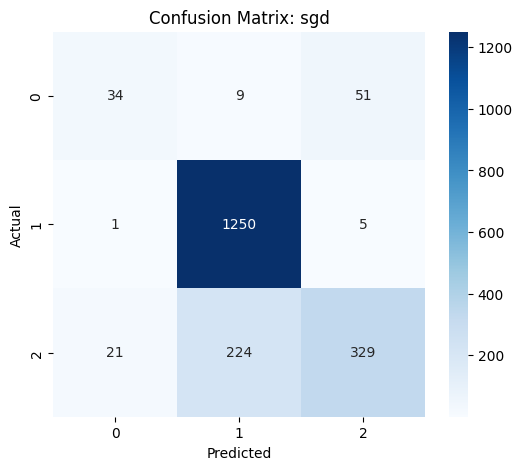


=== Training logistic ===
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best params: {'model__C': 1.319496149042566, 'model__fit_intercept': False, 'model__l1_ratio': 0.5, 'model__penalty': 'l1'}
Metrics: {'accuracy': 0.8653846153846154, 'balanced_accuracy': 0.7447922692060639, 'log_loss': 0.3390112968541857, 'roc_auc': 0.9347473264809084, 'f1_weighted': 0.8576830574278919}


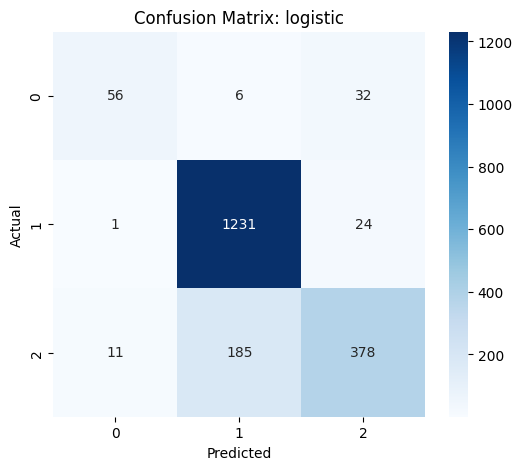


=== Summary Table ===


,Model,CV Score,Accuracy,Balanced Accuracy,Log Loss,ROC AUC,F1 Weighted
1,logistic,-0.337059,0.865385,0.744792,0.339011,0.934747,0.857683
0,sgd,-0.852331,0.838358,0.643365,0.869530,0.904607,0.822691


In [15]:
# train all models
results = train_and_evaluate(X_train, y_train_enc, X_test, y_test_enc, model_dict={'sgd': models['sgd'], 'logistic': models['logistic']})


In [16]:
results

({'sgd': {'best_model': Pipeline(steps=[('preprocess',
                    ColumnTransformer(remainder='passthrough',
                                      transformers=[('num',
                                                     Pipeline(steps=[('imputer',
                                                                      SimpleImputer(strategy='median')),
                                                                     ('scaler',
                                                                      MinMaxScaler())]),
                                                     ['owner_age',
                                                      'personal_income',
                                                      'business_expenses',
                                                      'business_turnover',
                                                      'business_age_years',
                                                      'business_age_months',
                        